In [0]:
import pandas as pd
import datetime as dt
from google.colab import drive
from google.colab import files
import seaborn as sb
!pip install xlrd
import xlrd
import functools
import matplotlib.pyplot as plt
sb.set_style("darkgrid")
import sklearn
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np
import seaborn as sns

In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
### DATA PROCESSING  
path = '/content/gdrive/My Drive/Python Final Project/Datasets/'
county_dens = pd.read_csv(path + 'PCounty_Dens.txt',sep='\t')
crime = pd.read_csv(path +'PCrime_Original.txt',sep='\t')
crime.timedate = pd.to_datetime(crime.timedate)
crime['Year'] = [x.year for x in crime.timedate]
crime['Month'] = [x.month for x in crime.timedate]

## LANDUSE 
landuse = pd.read_csv(path + 'LanduseFiltered.txt',sep='\t')
landuse['block'] = landuse['block'].fillna(0)
landuse['block'] = landuse['block'].astype(int)
landuse = landuse.drop_duplicates('block')
## Demographic
dem = pd.read_csv(path + 'demographicDataFull.csv')
## MERGE TABLES 
crimeDem = crime.merge(dem,left_on='censustract',right_on='tract',how='inner')
TotalDF = crimeDem.merge(landuse, on='block',how='inner')
TotalDF['YearTract'] = [str(x) + '_' + str(y) for x,y in zip(TotalDF.Year,TotalDF.tract)]

## Create More columns and index by primary key
def parseAgg(obj,series):
  selectEl = series[series ==obj]
  return len(selectEl)


### Add columns for use_simple 
useSimpleNames = set(TotalDF.use_simple)
solDem = TotalDF.drop_duplicates('block')
collection = pd.DataFrame(solDem.groupby('tract').date.count())
for name in useSimpleNames:
  parseData = solDem.groupby('tract').agg({'use_simple': [functools.partial(parseAgg,name)]})
  collection = pd.concat([collection,parseData],axis = 1)

collection.columns = collection.columns = ['Total'] + list(useSimpleNames)
## Filtering out crime type but welcome to use if you want
colFilter = ['date','time','ucr','crime_cat','long','lat', \
                           'crimetype','timedate','weekday','block','BLOCK'\
                           ,'blockgroup','censustract','Unnamed: 0','state_x','county_x',\
             'BLOCK','BLKGRP','TRACT','state_y','county_y','use_detail','use_color','use_simple']
dfAgg = TotalDF.drop(colFilter,axis=1)
dfAgg = dfAgg.drop_duplicates('YearTract')

YearTractDF = dfAgg.merge(collection.reset_index(),on='tract')
Yvar = TotalDF.groupby('YearTract').count().reset_index()[['YearTract','date']]
Yvar.columns = ['YearTract','Y']
YearTractDF = YearTractDF.merge(Yvar,on='YearTract')



In [0]:
YearTractDF = YearTractDF[np.isfinite(YearTractDF['Income'])]

In [0]:
### Overall Function
def analysisGivenYear(year):
  DFGen = YearTractDF[YearTractDF['Year']==year]
  YGen = DFGen.loc[: , "Y"]
  XGen = DFGen.drop(columns=['Y', 'YearTract'])
  X_train, X_test, y_train, y_test = train_test_split(XGen, YGen, test_size=0.2)
  #train linear regression model
  lm = linear_model.LinearRegression()
  linearmodel = lm.fit(X_train, y_train)
  linearpredictions = lm.predict(X_test)

  #train SV regression model
  svr = SVR()
  svrmodel = svr.fit(X_train, y_train)
  svrpredictions = svr.predict(X_test)

  #train Decision Tree Regressor
  dectree = DecisionTreeRegressor(max_depth=5)
  dectreemodel = dectree.fit(X_train, y_train)
  dectreepredictions = dectree.predict(X_test)

  #train Random Forest Regressor
  randtree = RandomForestRegressor(max_depth=5, random_state=0)
  randtreemodel = randtree.fit(X_train, y_train)
  randtreepredictions = randtree.predict(X_test)

  #train Multilayer Perceptron
  mlp = MLPRegressor()
  mlpmodel = mlp.fit(X_train, y_train)
  mlppredictions = mlp.predict(X_test)

  #plotting
  lin = plt.figure(1)
  plt.scatter(y_test, linearpredictions)
  plt.xlabel("True Values")
  plt.ylabel("Linear Predicted Values")
  lin.show()

  sup = plt.figure(2)
  plt.scatter(y_test, svrpredictions)
  plt.xlabel("True Values")
  plt.ylabel("Support Vector Regression Predicted Values")
  sup.show()

  dec = plt.figure(3)
  plt.scatter(y_test, dectreepredictions)
  plt.xlabel("True Values")
  plt.ylabel("Decision Tree Regression Predicted Values")
  dec.show()

  rand = plt.figure(4)
  plt.scatter(y_test, randtreepredictions)
  plt.xlabel("True Values")
  plt.ylabel("Rando Forest Regression Predicted Values")
  rand.show()

  #mlpp = plt.figure(5)
  #plt.scatter(y_test, mlppredictions)
  #plt.xlabel("True Values")
  #plt.ylabel("Multi-Layer Perceptron Predicted Values")
  #mlpp.show()

  print("Linear Regression Score:")
  print(linearmodel.score(X_test, y_test))
  print("Support Vector Regression Score:")
  print(svrmodel.score(X_test, y_test))
  print("Decision Tree Regression Score:")
  print(dectreemodel.score(X_test, y_test))
  print("Random Forest Regression Score:")
  print(randtreemodel.score(X_test, y_test))

  barchart = plt.figure(5)
  modelnames = ("Linear Regression", "Support Vector", "Decision Tree", "Random Forest")
  scores = [linearmodel.score(X_test, y_test), svrmodel.score(X_test, y_test), dectreemodel.score(X_test, y_test), randtreemodel.score(X_test, y_test)]
  plt.bar(modelnames, scores)
  barchart.show()

  input()
  
  

In [0]:
#Remove NA values from Income
YearTractDF = YearTractDF[np.isfinite(YearTractDF['Income'])]

DF2006 = YearTractDF[YearTractDF['Year']==2006]
DF2007 = YearTractDF[YearTractDF['Year']==2007]
DF2008 = YearTractDF[YearTractDF['Year']==2008]
DF2009 = YearTractDF[YearTractDF['Year']==2009]
DF2010 = YearTractDF[YearTractDF['Year']==2010]
DF2011 = YearTractDF[YearTractDF['Year']==2011]
DF2012 = YearTractDF[YearTractDF['Year']==2012]
DF2013 = YearTractDF[YearTractDF['Year']==2013]
DF2014 = YearTractDF[YearTractDF['Year']==2014]
DF2015 = YearTractDF[YearTractDF['Year']==2015]

#Set 'X' and 'Y' dataframes
Y2006 = DF2006.loc[: , "Y"]
X2006 = DF2006.drop(columns=['Y', 'YearTract'])
Y2007 = DF2007.loc[: , "Y"]
X2007 = DF2007.drop(columns=['Y', 'YearTract'])
Y2008 = DF2008.loc[: , "Y"]
X2008 = DF2008.drop(columns=['Y', 'YearTract'])
Y2009 = DF2009.loc[: , "Y"]
X2009 = DF2009.drop(columns=['Y', 'YearTract'])
Y2010 = DF2010.loc[: , "Y"]
X2010 = DF2010.drop(columns=['Y', 'YearTract'])
Y2011 = DF2011.loc[: , "Y"]
X2011 = DF2011.drop(columns=['Y', 'YearTract'])
Y2012 = DF2012.loc[: , "Y"]
X2012 = DF2012.drop(columns=['Y', 'YearTract'])
Y2013 = DF2013.loc[: , "Y"]
X2013 = DF2013.drop(columns=['Y', 'YearTract'])
Y2014 = DF2014.loc[: , "Y"]
X2014 = DF2014.drop(columns=['Y', 'YearTract'])
Y2015 = DF2015.loc[: , "Y"]
X2015 = DF2015.drop(columns=['Y', 'YearTract'])
#totalDF = TotalDF.drop(columns=['Y', 'YearTract'])


In [0]:
#Confirm loss of NA
X2006.shape
sum(X2006['Income'].isnull())
X2007.shape
sum(Y2007.isnull())

0

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Linear Regression Score:
0.6375205965213017
Support Vector Regression Score:
-0.0013798094205079714
Decision Tree Regression Score:
0.041330689686700284
Random Forest Regression Score:
0.6462738311150387



''

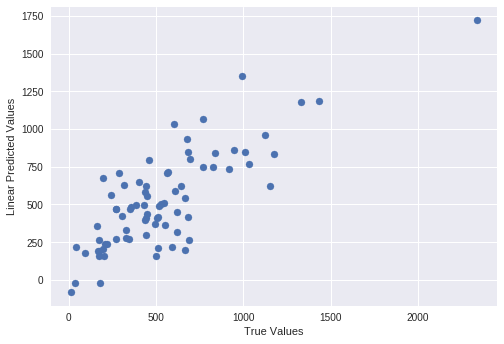

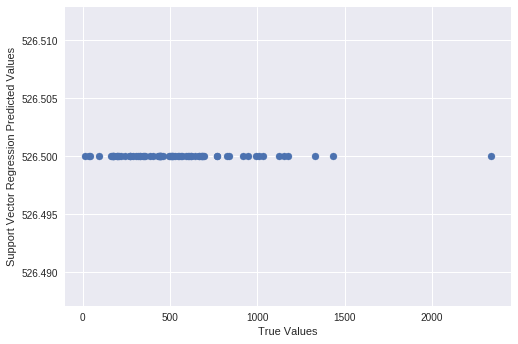

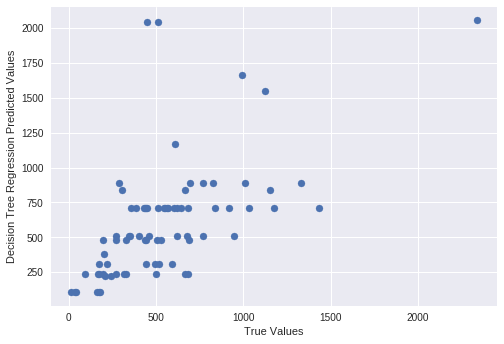

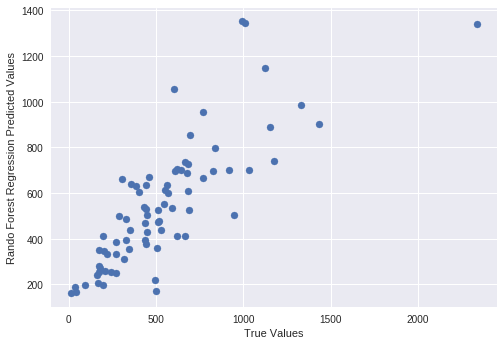

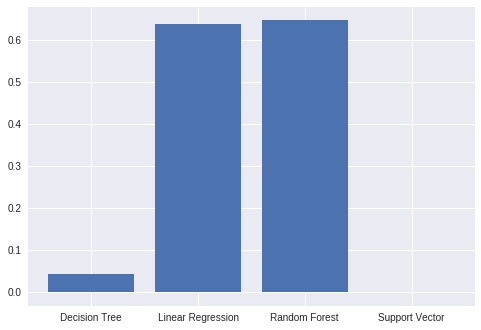

In [0]:
#RESULTS FOR 2006 DATA

#split into testing and training
X_train, X_test, y_train, y_test = train_test_split(X2006, Y2006, test_size=0.2)


#train linear regression model
lm = linear_model.LinearRegression()
linearmodel = lm.fit(X_train, y_train)
linearpredictions = lm.predict(X_test)

#train SV regression model
svr = SVR()
svrmodel = svr.fit(X_train, y_train)
svrpredictions = svr.predict(X_test)

#train Decision Tree Regressor
dectree = DecisionTreeRegressor(max_depth=5)
dectreemodel = dectree.fit(X_train, y_train)
dectreepredictions = dectree.predict(X_test)

#train Random Forest Regressor
randtree = RandomForestRegressor(max_depth=5, random_state=0)
randtreemodel = randtree.fit(X_train, y_train)
randtreepredictions = randtree.predict(X_test)

#train Multilayer Perceptron
mlp = MLPRegressor()
mlpmodel = mlp.fit(X_train, y_train)
mlppredictions = mlp.predict(X_test)

#plotting
lin = plt.figure(1)
plt.scatter(y_test, linearpredictions)
plt.xlabel("True Values")
plt.ylabel("Linear Predicted Values")
lin.show()

sup = plt.figure(2)
plt.scatter(y_test, svrpredictions)
plt.xlabel("True Values")
plt.ylabel("Support Vector Regression Predicted Values")
sup.show()

dec = plt.figure(3)
plt.scatter(y_test, dectreepredictions)
plt.xlabel("True Values")
plt.ylabel("Decision Tree Regression Predicted Values")
dec.show()

rand = plt.figure(4)
plt.scatter(y_test, randtreepredictions)
plt.xlabel("True Values")
plt.ylabel("Rando Forest Regression Predicted Values")
rand.show()

#mlpp = plt.figure(5)
#plt.scatter(y_test, mlppredictions)
#plt.xlabel("True Values")
#plt.ylabel("Multi-Layer Perceptron Predicted Values")
#mlpp.show()

print("Linear Regression Score:")
print(linearmodel.score(X_test, y_test))
print("Support Vector Regression Score:")
print(svrmodel.score(X_test, y_test))
print("Decision Tree Regression Score:")
print(dectreemodel.score(X_test, y_test))
print("Random Forest Regression Score:")
print(randtreemodel.score(X_test, y_test))

barchart = plt.figure(5)
modelnames = ("Linear Regression", "Support Vector", "Decision Tree", "Random Forest")
scores = [linearmodel.score(X_test, y_test), svrmodel.score(X_test, y_test), dectreemodel.score(X_test, y_test), randtreemodel.score(X_test, y_test)]
plt.bar(modelnames, scores)
barchart.show()

input()
#print("Multi-Layer Perceptron Regressor Score:")
#print(mlpmodel.score(X_test, y_test))


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Linear Regression Score:
0.8259793211431204
Support Vector Regression Score:
-0.017450806199018398
Decision Tree Regression Score:
0.32610980536846257
Random Forest Regression Score:
0.688961188723826



''

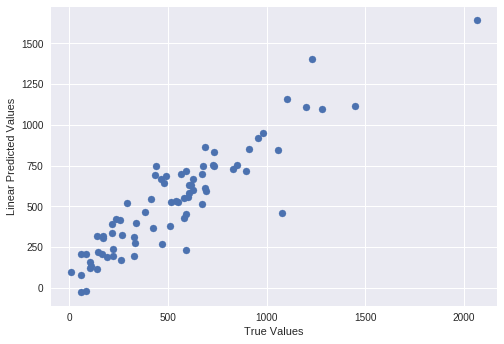

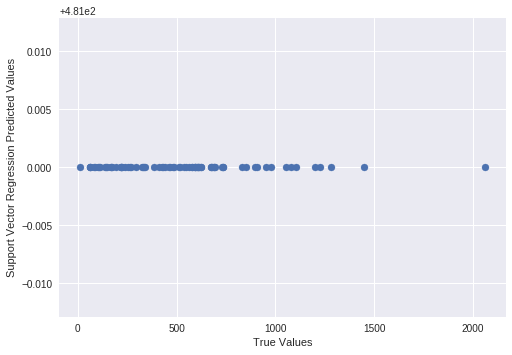

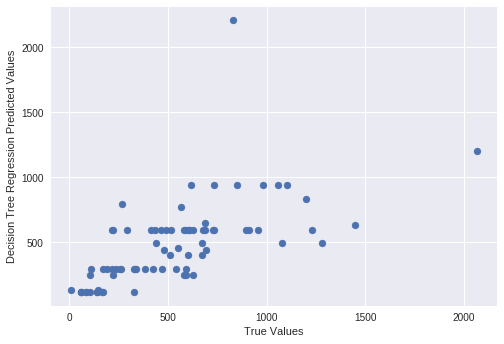

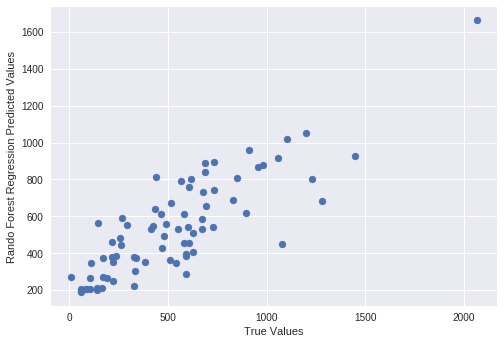

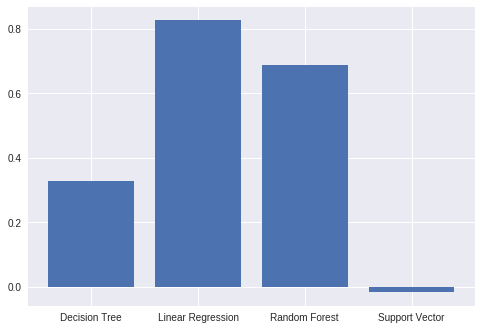

In [0]:
#RESULTS FOR 2007 DATA

#split into testing and training
X_train, X_test, y_train, y_test = train_test_split(X2007, Y2007, test_size=0.2)


#train linear regression model
lm = linear_model.LinearRegression()
linearmodel = lm.fit(X_train, y_train)
linearpredictions = lm.predict(X_test)

#train SV regression model
svr = SVR()
svrmodel = svr.fit(X_train, y_train)
svrpredictions = svr.predict(X_test)

#train Decision Tree Regressor
dectree = DecisionTreeRegressor(max_depth=5)
dectreemodel = dectree.fit(X_train, y_train)
dectreepredictions = dectree.predict(X_test)

#train Random Forest Regressor
randtree = RandomForestRegressor(max_depth=5, random_state=0)
randtreemodel = randtree.fit(X_train, y_train)
randtreepredictions = randtree.predict(X_test)

#train Multilayer Perceptron
mlp = MLPRegressor()
mlpmodel = mlp.fit(X_train, y_train)
mlppredictions = mlp.predict(X_test)

#plotting
lin = plt.figure(1)
plt.scatter(y_test, linearpredictions)
plt.xlabel("True Values")
plt.ylabel("Linear Predicted Values")
lin.show()

sup = plt.figure(2)
plt.scatter(y_test, svrpredictions)
plt.xlabel("True Values")
plt.ylabel("Support Vector Regression Predicted Values")
sup.show()

dec = plt.figure(3)
plt.scatter(y_test, dectreepredictions)
plt.xlabel("True Values")
plt.ylabel("Decision Tree Regression Predicted Values")
dec.show()

rand = plt.figure(4)
plt.scatter(y_test, randtreepredictions)
plt.xlabel("True Values")
plt.ylabel("Rando Forest Regression Predicted Values")
rand.show()

#mlpp = plt.figure(5)
#plt.scatter(y_test, mlppredictions)
#plt.xlabel("True Values")
#plt.ylabel("Multi-Layer Perceptron Predicted Values")
#mlpp.show()






print("Linear Regression Score:")
print(linearmodel.score(X_test, y_test))
print("Support Vector Regression Score:")
print(svrmodel.score(X_test, y_test))
print("Decision Tree Regression Score:")
print(dectreemodel.score(X_test, y_test))
print("Random Forest Regression Score:")
print(randtreemodel.score(X_test, y_test))
#print("Multi-Layer Perceptron Regressor Score:")
#print(mlpmodel.score(X_test, y_test))

barchart = plt.figure(5)
modelnames = ("Linear Regression", "Support Vector", "Decision Tree", "Random Forest")
scores = [linearmodel.score(X_test, y_test), svrmodel.score(X_test, y_test), dectreemodel.score(X_test, y_test), randtreemodel.score(X_test, y_test)]
plt.bar(modelnames, scores)
barchart.show()

input()


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Linear Regression Score:
0.6237128200133157
Support Vector Regression Score:
-0.023827203041748343
Decision Tree Regression Score:
0.18049700839269112
Random Forest Regression Score:
0.5533024894344599



''

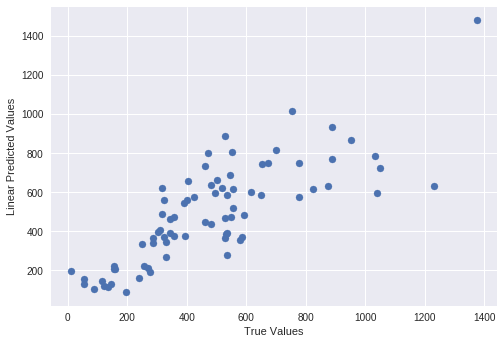

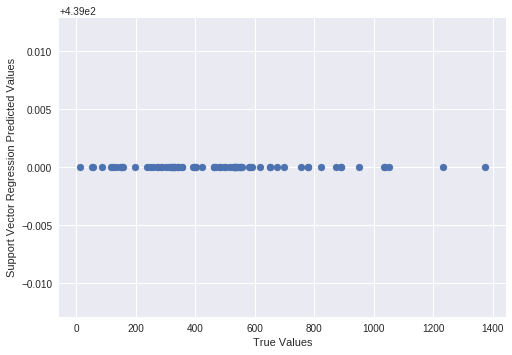

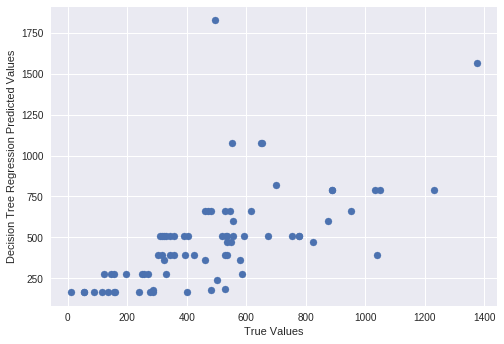

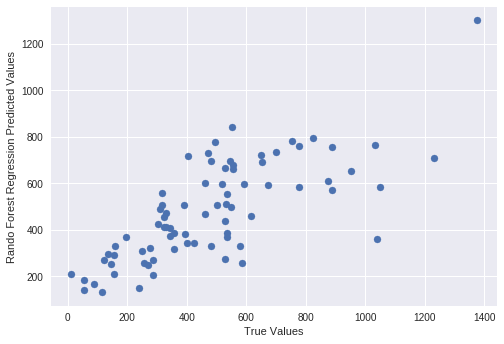

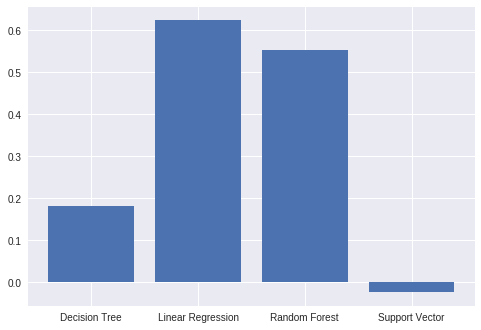

In [0]:
#RESULTS FOR 2010 DATA

#split into testing and training
X_train, X_test, y_train, y_test = train_test_split(X2010, Y2010, test_size=0.2)


#train linear regression model
lm = linear_model.LinearRegression()
linearmodel = lm.fit(X_train, y_train)
linearpredictions = lm.predict(X_test)

#train SV regression model
svr = SVR()
svrmodel = svr.fit(X_train, y_train)
svrpredictions = svr.predict(X_test)

#train Decision Tree Regressor
dectree = DecisionTreeRegressor(max_depth=5)
dectreemodel = dectree.fit(X_train, y_train)
dectreepredictions = dectree.predict(X_test)

#train Random Forest Regressor
randtree = RandomForestRegressor(max_depth=5, random_state=0)
randtreemodel = randtree.fit(X_train, y_train)
randtreepredictions = randtree.predict(X_test)

#train Multilayer Perceptron
mlp = MLPRegressor()
mlpmodel = mlp.fit(X_train, y_train)
mlppredictions = mlp.predict(X_test)

#plotting
lin = plt.figure(1)
plt.scatter(y_test, linearpredictions)
plt.xlabel("True Values")
plt.ylabel("Linear Predicted Values")
lin.show()

sup = plt.figure(2)
plt.scatter(y_test, svrpredictions)
plt.xlabel("True Values")
plt.ylabel("Support Vector Regression Predicted Values")
sup.show()

dec = plt.figure(3)
plt.scatter(y_test, dectreepredictions)
plt.xlabel("True Values")
plt.ylabel("Decision Tree Regression Predicted Values")
dec.show()

rand = plt.figure(4)
plt.scatter(y_test, randtreepredictions)
plt.xlabel("True Values")
plt.ylabel("Rando Forest Regression Predicted Values")
rand.show()

#mlpp = plt.figure(5)
#plt.scatter(y_test, mlppredictions)
#plt.xlabel("True Values")
#plt.ylabel("Multi-Layer Perceptron Predicted Values")
#mlpp.show()






print("Linear Regression Score:")
print(linearmodel.score(X_test, y_test))
print("Support Vector Regression Score:")
print(svrmodel.score(X_test, y_test))
print("Decision Tree Regression Score:")
print(dectreemodel.score(X_test, y_test))
print("Random Forest Regression Score:")
print(randtreemodel.score(X_test, y_test))
#print("Multi-Layer Perceptron Regressor Score:")
#print(mlpmodel.score(X_test, y_test))

barchart = plt.figure(5)
modelnames = ("Linear Regression", "Support Vector", "Decision Tree", "Random Forest")
scores = [linearmodel.score(X_test, y_test), svrmodel.score(X_test, y_test), dectreemodel.score(X_test, y_test), randtreemodel.score(X_test, y_test)]
plt.bar(modelnames, scores)
barchart.show()

input()


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Linear Regression Score:
0.373030921934805
Support Vector Regression Score:
-0.00899829597837587
Decision Tree Regression Score:
0.029676272823113137
Random Forest Regression Score:
0.36142387898444106



''

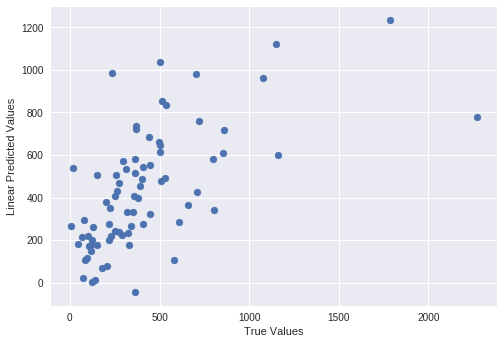

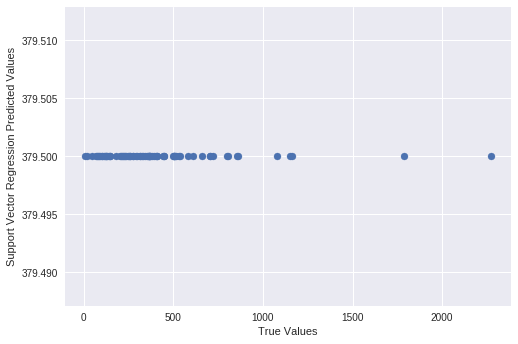

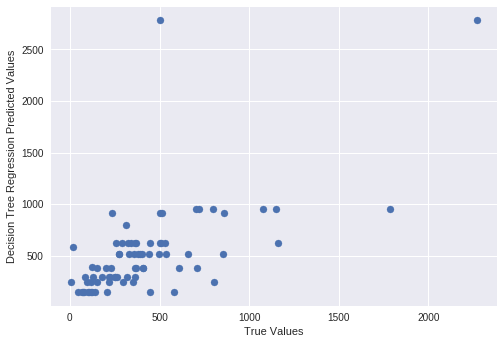

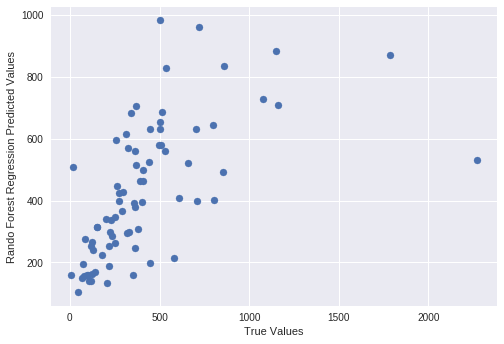

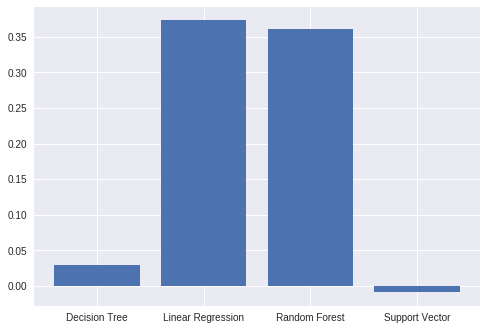

In [0]:
#RESULTS FOR 2015 DATA

#split into testing and training
X_train, X_test, y_train, y_test = train_test_split(X2015, Y2015, test_size=0.2)


#train linear regression model
lm = linear_model.LinearRegression()
linearmodel = lm.fit(X_train, y_train)
linearpredictions = lm.predict(X_test)

#train SV regression model
svr = SVR()
svrmodel = svr.fit(X_train, y_train)
svrpredictions = svr.predict(X_test)

#train Decision Tree Regressor
dectree = DecisionTreeRegressor(max_depth=5)
dectreemodel = dectree.fit(X_train, y_train)
dectreepredictions = dectree.predict(X_test)

#train Random Forest Regressor
randtree = RandomForestRegressor(max_depth=5, random_state=0)
randtreemodel = randtree.fit(X_train, y_train)
randtreepredictions = randtree.predict(X_test)

#train Multilayer Perceptron
mlp = MLPRegressor()
mlpmodel = mlp.fit(X_train, y_train)
mlppredictions = mlp.predict(X_test)

#plotting
lin = plt.figure(1)
plt.scatter(y_test, linearpredictions)
plt.xlabel("True Values")
plt.ylabel("Linear Predicted Values")
lin.show()

sup = plt.figure(2)
plt.scatter(y_test, svrpredictions)
plt.xlabel("True Values")
plt.ylabel("Support Vector Regression Predicted Values")
sup.show()

dec = plt.figure(3)
plt.scatter(y_test, dectreepredictions)
plt.xlabel("True Values")
plt.ylabel("Decision Tree Regression Predicted Values")
dec.show()

rand = plt.figure(4)
plt.scatter(y_test, randtreepredictions)
plt.xlabel("True Values")
plt.ylabel("Rando Forest Regression Predicted Values")
rand.show()

#mlpp = plt.figure(5)
#plt.scatter(y_test, mlppredictions)
#plt.xlabel("True Values")
#plt.ylabel("Multi-Layer Perceptron Predicted Values")
#mlpp.show()

print("Linear Regression Score:")
print(linearmodel.score(X_test, y_test))
print("Support Vector Regression Score:")
print(svrmodel.score(X_test, y_test))
print("Decision Tree Regression Score:")
print(dectreemodel.score(X_test, y_test))
print("Random Forest Regression Score:")
print(randtreemodel.score(X_test, y_test))

barchart = plt.figure(5)
modelnames = ("Linear Regression", "Support Vector", "Decision Tree", "Random Forest")
scores = [linearmodel.score(X_test, y_test), svrmodel.score(X_test, y_test), dectreemodel.score(X_test, y_test), randtreemodel.score(X_test, y_test)]
plt.bar(modelnames, scores)
barchart.show()

input()
#print("Multi-Layer Perceptron Regressor Score:")
#print(mlpmodel.score(X_test, y_test))


**Next Steps Notes:**

Split data into training and test by tracts (I made the primary key year tract so you have some flexibility with this)
Predictive variable is called "Y" it is the number of crimes per year per tract.
Start with any type of regression model and then go from there make sure to keep track of the out of sample errors.
If time

Filter by different crime type
Filter by different years or try to predict the subsequent years
Experiment with online learning